## Importing Libraries

In [24]:
import numpy as np
import pandas as pd
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt



## Generating Data 

Here we are trying to generate the dataset for the poisson regression problem. This code is written to generate a dataset with 3 independent variables/covariates. If one wish to add more variables simply add more X_i s following particular distribution according to the probelm. To generate the respons variables first we generated the covariates and genereated mean of the responses by simply following the canonical link for poisson distributed data. Finally, the response variables were generated by drawing samples from a distribution with calculated mean.

In [25]:

def generate_poisson_data(n=10, beta0=1, betas=[0.2, 0.3, -0.1]):
    
    #Generates data for a Poisson regression model with three specific predictors:
    #X1 - Uniformly distributed,
    #X2 - Normally distributed (mean=0, std=1),
    #X3 - Normally distributed (mean=2, std=1).
    
    #Input:
    #    n (int): Number of samples.
    #    beta0 (float): Intercept coefficient.
    #    betas (list of float): Coefficients for the predictor variables, [beta1, beta2, beta3].
    
    #Output:
    #   X (ndarray): 2D array of predictor values.
    #   y (ndarray): Array of response values from the Poisson distribution.
    
    # Generate covariate values
    X1 = np.random.uniform(low=0, high=1.5, size=n)   # X1 - Uniform distribution
    X2 = np.random.uniform(low=-1, high=1, size=n)   # X2 - Uniform distribution
    X3 = np.random.uniform(low=1, high=3, size=n)   # X3 - Uniform distribution
    X = np.column_stack((X1, X2, X3))                 # Stack arrays column-wise

    # Compute linear predictor as beta0 + sum(betas * X, axis=1)
    linear_predictor = beta0 + np.dot(X, np.array(betas))
    
    # Compute mu's using the exponential link function
    mu = np.exp(linear_predictor)
    
    # Generate Y-values from a Poisson distribution
    y = np.random.poisson(lam=mu)
    
    return X, y

## Function for Poisson Regression

In [26]:
class PoissonRegression(nn.Module):
    def __init__(self, input_dim, use_bias=True):
        super(PoissonRegression, self).__init__()
        # In Poisson regression, we typically include the bias to handle the intercept
        self.linear = nn.Linear(input_dim, 1, bias=use_bias)
    
    def forward(self, x):
        # Applying the linear layer and exponentiating the output
        # to ensure the rate parameter λ is positive
        return torch.exp(self.linear(x))

def train_poisson_regression(X_data, Y_data, epochs=200, learning_rate=0.1, use_bias=False):
    input_dim = X_data.shape[1]
    
    # Converting X, y into tensors
    X_data = torch.tensor(X_data, dtype=torch.float32)
    Y_data = torch.tensor(Y_data, dtype=torch.float32).view(-1, 1)
    
    # Creating the instance of Poisson regression
    model = PoissonRegression(input_dim, use_bias)
    
    # Poisson loss (negative log likelihood)
    criterion = torch.nn.PoissonNLLLoss(log_input=False)  # Set `log_input=False` because our model already outputs exp(linear(x))
    
    # Using a stochastic gradient descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    all_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_data)
        loss = criterion(outputs, Y_data)
        all_losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    plt.plot(all_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, all_losses

##  Experiment 1 

### Data Generation

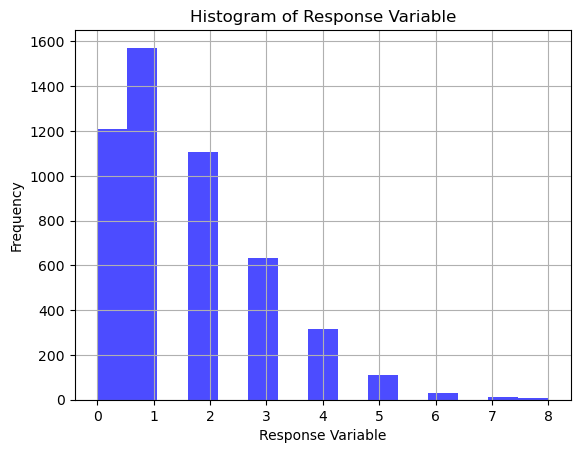

In [15]:

samples = 5000
bias = 0
betas = [0.8,0.2,-0.1 ]
X,y = generate_poisson_data(samples, bias, betas)

# Plotting the histogram of 'y'
plt.hist(y, bins=15, color='blue', alpha=0.7)  # You can adjust the number of bins and color as needed
plt.xlabel('Response Variable')
plt.ylabel('Frequency')
plt.title('Histogram of Response Variable')
plt.grid(True)
plt.show()

n_train = 4000
n_test = 1000

X_train = X[0:(n_train),:]
y_train = y[0:(n_train)]
X_test = X[(n_train):(n_train+n_test),:]
y_test = y[(n_train):(n_train+n_test)]


### Poisson Regression

In [44]:
#fitting the poisson model 

intercept = False

Regressor = PoissonRegressor(alpha=0, max_iter=300,fit_intercept=intercept)
Regressor.fit(X_train, y_train)

print("Coefficients of the model:", Regressor.coef_)
if intercept: print("Intercept:", Regressor.intercept_)

#estimation 

# Calculate the squared norm of the difference between true and estimated parameters
error_norm = np.linalg.norm(betas - Regressor.coef_ ) ** 2
    
# Calculate the norm of the true parameters
true_norm = np.linalg.norm(betas)

#normalized estimation error 
nee = error_norm/true_norm
print('Normalised Estimation Error for parameter estimation:',nee)

#Testing

y_test_predicted = np.round(Regressor.predict(X_test)).astype(int)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_predicted)

print("Mean Squared Error:", mse)

Coefficients of the model: [ 0.7841327   0.18733254 -0.10547925]
Normalised Estimation Error for parameter estimation: 0.000532415836780194
Mean Squared Error: 1.656


Epoch [10/600], Loss: 0.9150
Epoch [20/600], Loss: 0.8652
Epoch [30/600], Loss: 0.8451
Epoch [40/600], Loss: 0.8362
Epoch [50/600], Loss: 0.8311
Epoch [60/600], Loss: 0.8274
Epoch [70/600], Loss: 0.8241
Epoch [80/600], Loss: 0.8211
Epoch [90/600], Loss: 0.8184
Epoch [100/600], Loss: 0.8158
Epoch [110/600], Loss: 0.8133
Epoch [120/600], Loss: 0.8110
Epoch [130/600], Loss: 0.8088
Epoch [140/600], Loss: 0.8067
Epoch [150/600], Loss: 0.8048
Epoch [160/600], Loss: 0.8029
Epoch [170/600], Loss: 0.8012
Epoch [180/600], Loss: 0.7996
Epoch [190/600], Loss: 0.7980
Epoch [200/600], Loss: 0.7966
Epoch [210/600], Loss: 0.7952
Epoch [220/600], Loss: 0.7939
Epoch [230/600], Loss: 0.7927
Epoch [240/600], Loss: 0.7915
Epoch [250/600], Loss: 0.7904
Epoch [260/600], Loss: 0.7894
Epoch [270/600], Loss: 0.7884
Epoch [280/600], Loss: 0.7875
Epoch [290/600], Loss: 0.7866
Epoch [300/600], Loss: 0.7858
Epoch [310/600], Loss: 0.7850
Epoch [320/600], Loss: 0.7843
Epoch [330/600], Loss: 0.7836
Epoch [340/600], Lo

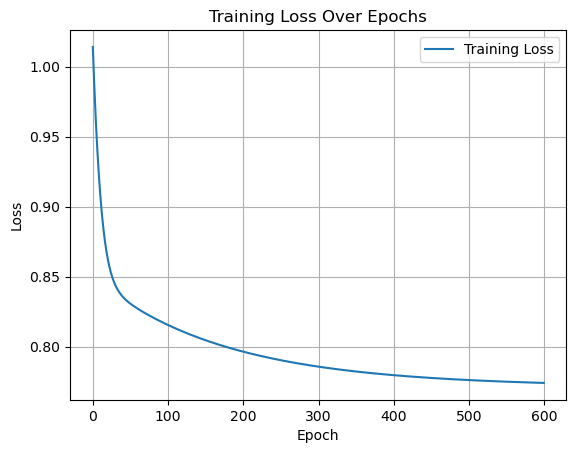

Estimated Model Paramter: [[ 0.6627013   0.22249769 -0.05490677]]
Normalised Estimation Error for parameter estimation: 0.025751106454261125
Mean Squred Error: 1.673


In [43]:
#Training 
learning_rate = 0.008
use_bias = False
epochs = 600
Regressor_torch,Losses = train_poisson_regression(X_train, y_train, epochs, learning_rate, use_bias)


#model parameter
print('Estimated Model Paramter:',Regressor_torch.linear.weight.data.numpy())
if use_bias:
    print('Estimated Bias:',Regressor_torch.linear.bias.item())

#estimation error

# Calculate the squared norm of the difference between true and estimated parameters
error_norm_torch = np.linalg.norm(betas - Regressor_torch.linear.weight.data.numpy() ) ** 2
    
# Calculate the norm of the true parameters
true_norm_torch = np.linalg.norm(betas)

#normalized estimation error 
nee_torch = error_norm_torch/true_norm_torch
print('Normalised Estimation Error for parameter estimation:',nee_torch)


#predtiction

y_test_predicted_torch = Regressor_torch(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
y_test_predicted_torch = np.round(y_test_predicted_torch).astype(int)

mse_torch = mean_squared_error(y_test, y_test_predicted_torch)
print('Mean Squred Error:',mse_torch)

